In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [21]:
df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858,2131.09


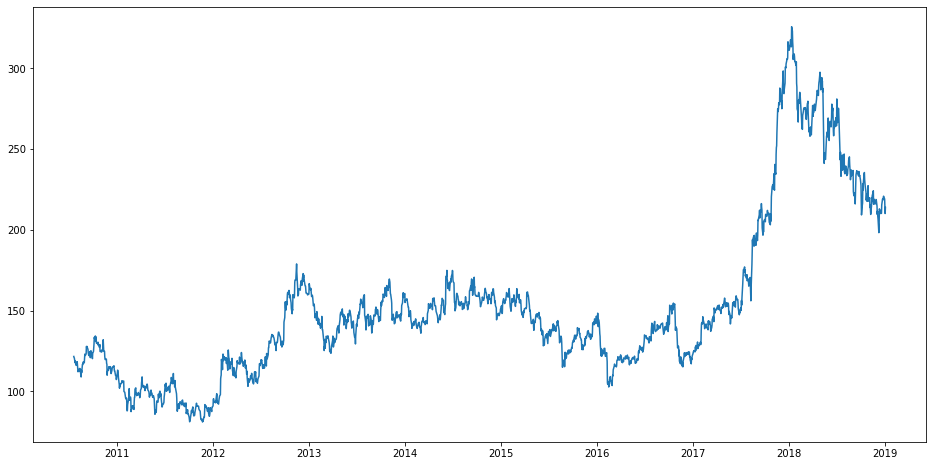

In [22]:
df["Date"]=pd.to_datetime(df.Date,format="%Y/%m/%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [48]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [49]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [50]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
# x_train_data=np.reshape(x_train_data.shape[0],-1)

# x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [51]:
x_train_data

array([[0.16584967, 0.16319444, 0.1621732 , ..., 0.21772876, 0.20445261,
        0.21568627],
       [0.16319444, 0.1621732 , 0.14971405, ..., 0.20445261, 0.21568627,
        0.2128268 ],
       [0.1621732 , 0.14971405, 0.15400327, ..., 0.21568627, 0.2128268 ,
        0.1997549 ],
       ...,
       [0.27389706, 0.28227124, 0.2994281 , ..., 0.35273693, 0.36172386,
        0.35477941],
       [0.28227124, 0.2994281 , 0.29636438, ..., 0.36172386, 0.35477941,
        0.3682598 ],
       [0.2994281 , 0.29636438, 0.28839869, ..., 0.35477941, 0.3682598 ,
        0.375     ]])

In [52]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
xgb_model.fit(x_train_data, y_train_data)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [56]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test[0, 0]

0.29636437908496727

In [58]:
val = np.array(X_test[0]).reshape(1, -1)
print(val)
pred = xgb_model.predict(val)
print(pred[0])

[[0.29636438 0.28839869 0.29105392 0.2879902  0.30004085 0.29473039
  0.29330065 0.29452614 0.28410948 0.3125     0.30718954 0.31413399
  0.30698529 0.29411765 0.29370915 0.28737745 0.27982026 0.2753268
  0.2685866  0.26205065 0.26000817 0.25122549 0.26164216 0.25980392
  0.26736111 0.27103758 0.25837418 0.26062092 0.28492647 0.29616013
  0.29473039 0.30473856 0.3129085  0.30841503 0.30821078 0.30759804
  0.27757353 0.27839052 0.27185458 0.28329248 0.2943219  0.29861111
  0.3682598  0.3686683  0.38357843 0.36111111 0.35825163 0.33803105
  0.34742647 0.35171569 0.3374183  0.33476307 0.33251634 0.35539216
  0.35273693 0.36172386 0.35477941 0.3682598  0.375      0.38337418]]
0.37333637


In [60]:
xgb_model.save_model("saved_xgb_model.h5")

In [35]:
# X_test=[]
# for i in range(60,inputs_data.shape[0]):
#     X_test.append(inputs_data[i-60:i,0])
# X_test=np.array(X_test)

# X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# closing_price=xgb_model.predict(X_test)
# closing_price=scaler.inverse_transform(closing_price)

XGBoostError: [10:02:57] c:\users\administrator\workspace\xgboost-win64_release_1.4.0\src\data\array_interface.h:208: Check failed: j_shape.size() == 2 (3 vs. 2) : Only 1-D and 2-D arrays are supported.

C:\Users\DUNG BUI\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


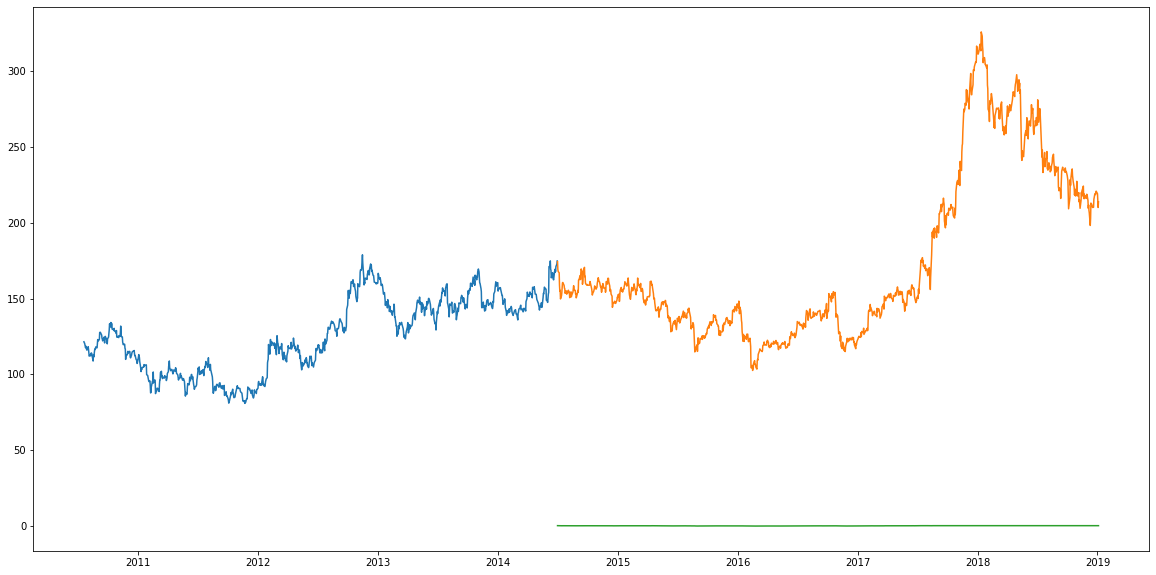

In [61]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']= closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])